In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.interpolate import PchipInterpolator

import csky as cy

mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots_nb.mplstyle')

In [51]:
dec = np.arcsin(0.5)
mjd = 58000.
ra = 0.
gamma = 2.
delta_gamma = -1*(gamma-1.)
e_bins = np.logspace(1., 8., 500)
e_cents = 10.**(np.log10(e_bins)[:-1] + np.diff(np.log10(e_bins))/2.)

cl = 0.68
# cl = 0.9 for 90% 

## Start by calculating the central 68% of the $\frac{dN}{dE}$

In [52]:
mc = np.load('/data/ana/analyses/gfu/version-002-p05/IC86_2011_MC.npy')

decs = np.radians([-30., 0., 30.])

sinDecs = np.linspace(-0.9, 0.9, 51)
decs = np.arcsin(sinDecs)

gammas = [2.0, 2.5, 3.0]
eff_area_central = dict()

for dec in decs:
    dec_mask = mc['dec'] > dec - (5. * np.pi / 180.)
    dec_mask *= mc['dec'] < dec + (5. * np.pi / 180.)
    eff_area_central[dec] = dict()
    for gamma in gammas:
        delta_gamma = -1*(gamma-1.)
        h, b = np.histogram(mc['trueE'][dec_mask], 
            weights = mc['ow'][dec_mask] * np.power(mc['trueE'][dec_mask], delta_gamma) / mc['trueE'][dec_mask], 
            bins = e_bins)

        cdf = np.cumsum(h) / np.sum(h)
        low = np.interp((1.0-cl)/2., cdf, b[:-1])
        median = np.interp(0.5, cdf, b[:-1])
        high = np.interp(1.0 - (1.0-cl)/2., cdf, b[:-1])

        eff_area_central[dec][gamma] = {'low': low, 'med': median, 'high': high}

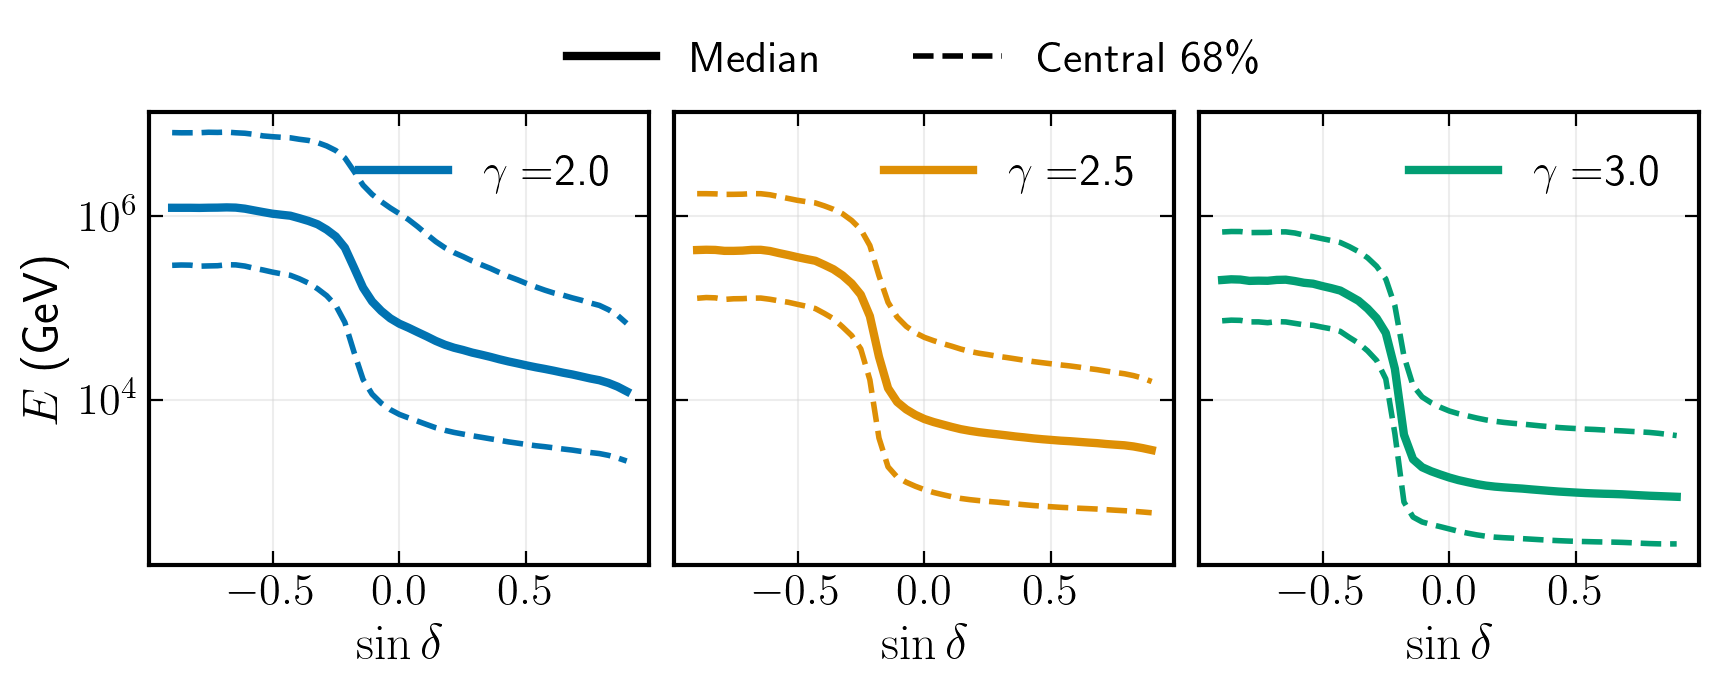

In [53]:
palette = sns.color_palette('colorblind', 9)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 3), sharey=True, dpi=200)
plt.subplots_adjust(hspace=0.05, wspace=0.05)

legend_elements = [Line2D([0], [0], color='k', lw=3, label='Median'),
                   Line2D([0], [0], color='k', lw=2., linestyle='--', label='Central 68\%')]
leg = plt.legend(handles=legend_elements, loc=(-1.3, 1.03), ncol=2, frameon=False)

for ii, gam in enumerate([2.0, 2.5, 3.0]):
    up_lims = np.array([eff_area_central[dec][gam]['high'] for dec in decs])
    low_lims = np.array([eff_area_central[dec][gam]['low'] for dec in decs])
    meds = np.array([eff_area_central[dec][gam]['med'] for dec in decs])
    
    axs[ii].plot(sinDecs, meds, color = palette[ii], lw=3., label=r'$\gamma = $' + f'{gam:.1f}')
    axs[ii].plot(sinDecs, up_lims, linestyle='--', color = palette[ii], lw=2.)
    axs[ii].plot(sinDecs, low_lims, linestyle='--', color = palette[ii], lw=2.)

    
    axs[ii].set_yscale('log')
    axs[ii].set_xlabel(r'$\sin \delta$')
    axs[ii].legend(loc=1, frameon=False)
    
    
plt.gca().add_artist(leg)

axs[0].set_ylabel(r'$E$ (GeV)')

plt.show()

## Now, compare

In [7]:
with open('results/central_energy_results_dec_0.0_gamma_3.0.pkl', 'rb') as fi:
    res = pickle.load(fi)

In [14]:
def load_sens_dict(dec, gamma):
    with open(f'results/central_energy_results_dec_{dec}_gamma_{gamma}.pkl', 'rb') as fi:
        res = pickle.load(fi)
    return res

def get_sens_vs_cut(dec, gamma, delta_t, cut = 'high'):
    res = load_sens_dict(dec, gamma)
    sens_dict = res[delta_t]
    ref_sens = sens_dict['no_cut']
    if cut == 'high':
        tmp = np.asarray(sens_dict['high_cut']).T
        ens = tmp[0]
        sens = tmp[1]
    elif cut == 'low':
        tmp = np.asarray(sens_dict['low_cut']).T
        ens = tmp[0]
        sens = tmp[1]
    if gamma == 2.5 and cut == 'low':
        sens = np.where(ens < 0.999e3, sens, sens*10**1.5)
    elif gamma == 3.0 and cut == 'low':
        sens = np.where(ens < 0.999e3, sens, sens*1e3)
    return ens, sens

def get_ref_sens(dec, gamma, delta_t):
    res = load_sens_dict(dec, gamma)
    sens_dict = res[delta_t]
    ref_sens = sens_dict['no_cut']
    return ref_sens

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_ind(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

@np.vectorize
def find_thresh_energy(dec, gamma, delta_t, cut='high', cl=0.68):
    ref_sens = get_ref_sens(dec, gamma, delta_t)
    ens, sens_vs_cut = get_sens_vs_cut(dec, gamma, delta_t, cut=cut)
    factor = 2./(1.+cl)
    ratios = sens_vs_cut / ref_sens
    ratio_spline= PchipInterpolator(np.log10(ens), ratios)
    test_es = np.linspace(np.log10(ens[0]), np.log10(ens[-1]), 500)
    nearest_ind = find_nearest_ind(ratio_spline(test_es), factor)
    return 10.**test_es[nearest_ind]

In [15]:
delta_ts = np.asarray(list(res.keys()))

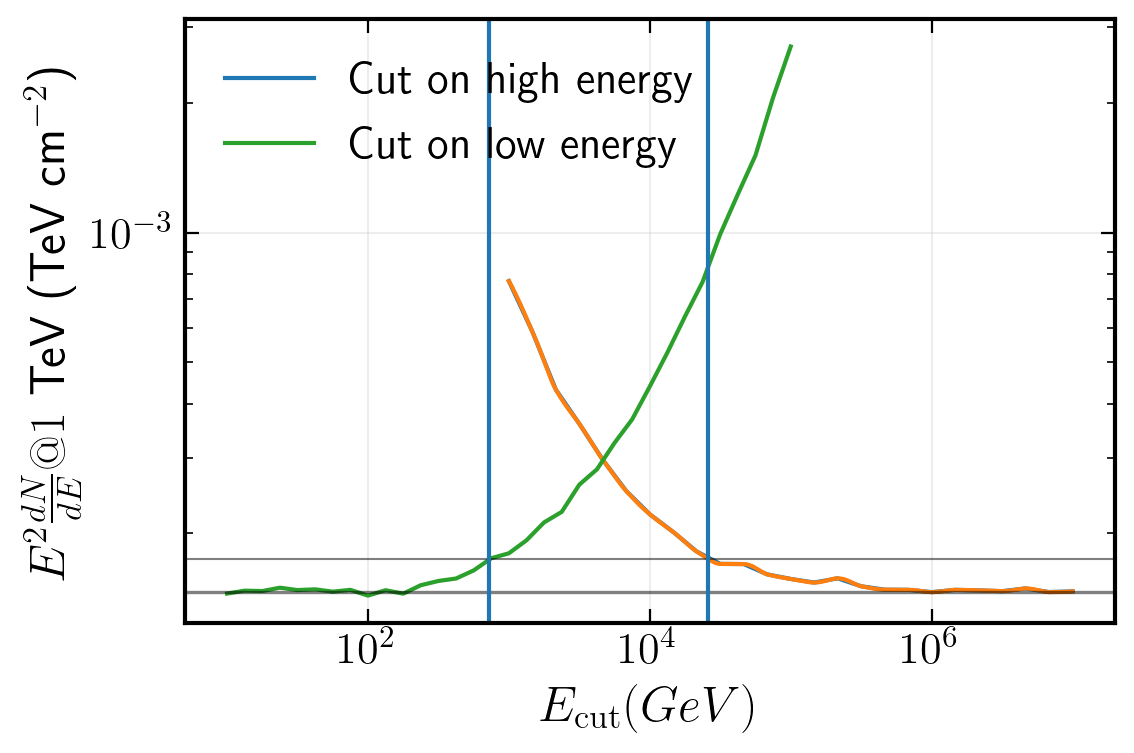

In [16]:
fig = plt.figure(dpi=200)

delta_t = 1e5
dec = 30.0
gamma = 2.5

e, s = get_sens_vs_cut(dec, gamma, delta_t, cut='high')
plt.plot(e, s, label = 'Cut on high energy')

pchip = PchipInterpolator(e, s)
ee = np.logspace(3., 7., 500)
plt.plot(ee, pchip(ee))

e, s = get_sens_vs_cut(dec, gamma, delta_t, cut='low')
plt.plot(e, s, label = 'Cut on low energy')

ref_sens = get_ref_sens(dec, gamma, delta_t)
plt.axhline(ref_sens, color = 'k', lw=1.2, alpha=0.5)

plt.axhline(ref_sens * (1./0.84), color = 'k', lw=0.75, alpha=0.5)
# plt.text(3e4, ref_sens*0.86, 'No cut', color='k')

plt.axvline(find_thresh_energy(dec, gamma, delta_t, cut='low', cl=0.68))
plt.axvline(find_thresh_energy(dec, gamma, delta_t, cut='high', cl=0.68))

plt.loglog()
plt.legend(frameon=False)
plt.xlabel(r"$E_{\mathrm{cut}} (GeV)$")
plt.ylabel(r'$E^2 \frac{dN}{dE} @ 1 $ TeV (TeV cm$^{-2}$)')

plt.show()

No handles with labels found to put in legend.


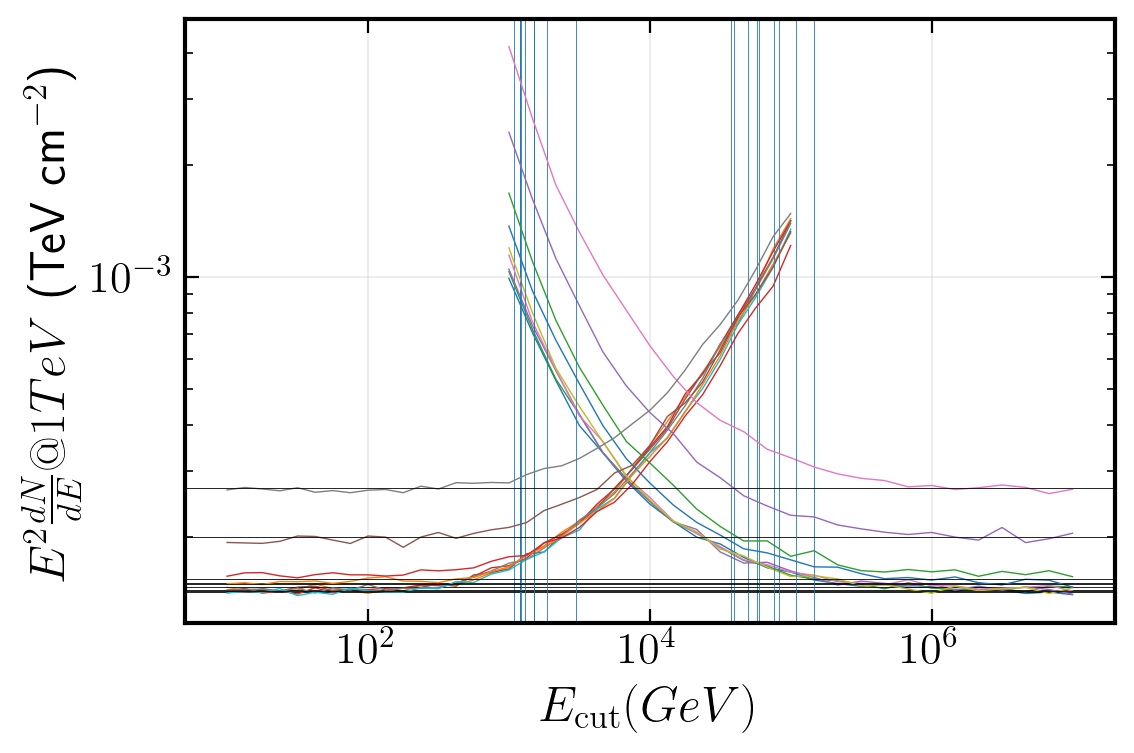

In [17]:
fig = plt.figure(dpi=200)

delta_t = 1e6
dec = 0.0
gamma = 2.5

for delta_t in delta_ts:
    e, s = get_sens_vs_cut(dec, gamma, delta_t, cut='high')
    plt.plot(e, s, lw=0.5)

    e, s = get_sens_vs_cut(dec, gamma, delta_t, cut='low')
    plt.plot(e, s, lw=0.5)
    
    plt.axvline(find_thresh_energy(dec, gamma, delta_t, cut='low', cl=0.68), lw=0.3)
    plt.axvline(find_thresh_energy(dec, gamma, delta_t, cut='high', cl=0.68), lw=0.3)

    ref_sens = get_ref_sens(dec, gamma, delta_t)
    plt.axhline(ref_sens, color = 'k', lw=0.3)

# plt.axhline(ref_sens * (1./0.84), color = 'k', lw=0.75, alpha=0.5)
# plt.text(3e4, ref_sens*0.86, 'No cut', color='k')

# plt.axvline(find_thresh_energy(dec, gamma, delta_t, cut='low', cl=0.68))
# plt.axvline(find_thresh_energy(dec, gamma, delta_t, cut='high', cl=0.68))

plt.loglog()
plt.legend(frameon=False)
plt.xlabel(r"$E_{\mathrm{cut}} (GeV)$")
plt.ylabel(r'$E^2 \frac{dN}{dE} @ 1 TeV$ (TeV cm$^{-2}$)')

plt.show()

In [18]:
def comparison_plot(dec, gamma, ax = None, title=True, ylab=True):
    '''dec in degrees'''
    if ax is None:
        fig, ax = plt.subplots()
    dec_ind = find_nearest_ind(decs, np.radians(dec))
    col_ind = {2.0: 0, 2.5: 1, 3.0: 2}[gamma]

    highs = find_thresh_energy(dec, gamma, delta_ts, cut='high', cl=0.68)
    lows = find_thresh_energy(dec, gamma, delta_ts, cut='low', cl=0.68)

    ax.fill_between(delta_ts, lows, highs, alpha=0.4, label = 'Sensitivity',
                     color = palette[col_ind]
#                     linestyle='-.', hatch='+', facecolor="none", 
#                      edgecolor = palette[col_ind]
                    )
    ax.axhline(eff_area_central[decs[dec_ind]][gamma]['low'], ls = '--', 
                label = 'Effective Area', lw=2., color=palette[col_ind])
    ax.axhline(eff_area_central[decs[dec_ind]][gamma]['high'], ls = '--',
               lw=2., color=palette[col_ind])

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\Delta T$ (s)')
    if ylab:
        ax.set_ylabel(r'$E_{\nu}$ (GeV)')
    ax.legend(loc=2, frameon=False)
    ax.set_ylim(1e2, 6e7)
    if title:
        ax.set_title(r'$\gamma = $' + f'{gamma:.1f}')
#         ax.set_title('Central 68\% Energy, ' + r'$\delta = $' + f'{dec:.0f}' \
#              + r'$^{\circ}$, $\gamma = $' + f'{gamma:.1f}')

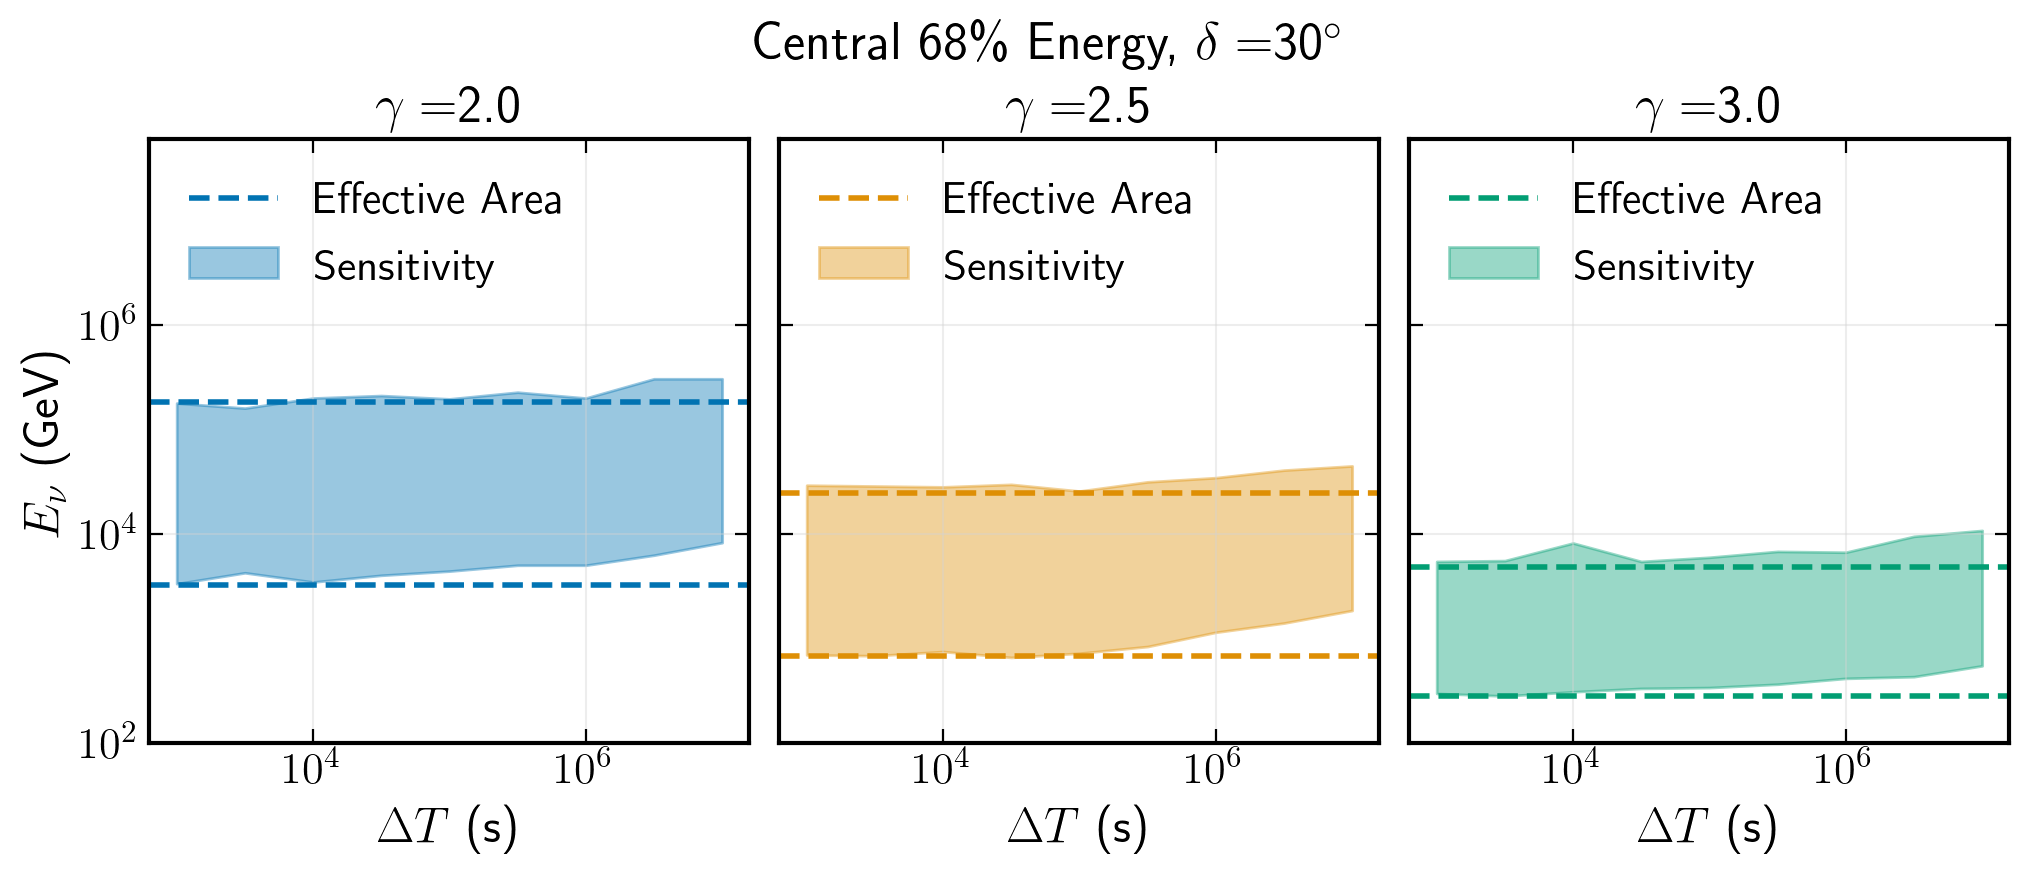

In [19]:
dec = 30.

fig, aaxs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=True, dpi=200)
axs = np.ravel(aaxs)
plt.subplots_adjust(wspace=0.05)
for i, gam in enumerate([2.0, 2.5, 3.0]):
    ylab = True if i == 0 else False
    comparison_plot(dec, gam, ax = axs[i], title=True, ylab=ylab)
plt.suptitle('Central 68\% Energy, ' + r'$\delta = $' + f'{dec:.0f}' \
            + r'$^{\circ}$', y=1.03)
plt.show()